In [1]:
from math import sqrt

import fastai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
DPI = 120

In [2]:
raw_data = pd.read_csv("old_data/raw_metacritic_game_user_comments.csv")
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

In [3]:
game_info_data

,Unnamed: 0,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2
2,2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2
4,4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player
...,...,...,...,...,...,...,...,...,...
4995,4995,Donut County,2018,BenEsposito,Action Adventure;General,PC,77,8.1,No Online Multiplayer
4996,4996,MotorStorm: Apocalypse,2011,EvolutionStudios,Driving;Racing;Simulation;Rally / Offroad;Rall...,PlayStation3,77,7.7,4 Online
4997,4997,The Last Guy,2008,SCEJapanStudio,Action Adventure;Sci-Fi;Sci-Fi;General,PlayStation3,77,6.8,1 Player
4998,4998,Valiant Hearts: The Great War,2014,UbisoftMontpellier,Platformer;2D;Action;Platformer;2D,PlayStation4,77,8.4,not specified


In [4]:
train_data

,Unnamed: 0,Userscore,Username,Game_ID
0,47246,9,SergeantSoz,119
1,199743,9,SergeantSoz,1540
2,235823,8,SergeantSoz,2227
3,263595,8,SergeantSoz,2941
4,72338,9,tomcrew10,238
...,...,...,...,...
105853,65974,10,Supersaiyan9000,198
105854,69938,10,Supersaiyan9000,218
105855,165164,10,Supersaiyan9000,1063
105856,231077,9,Supersaiyan9000,2137


In [6]:
train_valid = pd.concat([train_data, valid_data])
np.unique(train_data["Userscore"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [7]:
us_mean = train_valid["Userscore"].mean()
us_max = train_valid["Userscore"].max()
us_min = train_valid["Userscore"].min()

def format_data(data, normalize=True):
    """
    previously dropped columns and concatenated game id to platform
    now only drops `Unnamed: 0`
    """
    fmt = data.drop(["Unnamed: 0"], axis=1)
    if normalize:
        fmt["Userscore"] = (fmt["Userscore"] - us_mean) / (us_max - us_min)
    return fmt

def group_data(data):
    """
    dict that maps username -> dataframe containing the user reviews
    """
    return dict(tuple(data.groupby('Username')))

train_valid_data_fmt = format_data(train_valid, normalize=False)
train_data_fmt = format_data(train_data, normalize=False)
test_data_fmt = format_data(test_data, normalize=False)
valid_data_fmt = format_data(valid_data, normalize=False)

In [10]:
def restrict_data(data, restrict):
    """
    gives the dataset where (# of reviews for a user) >= restrict
    """
    dfs = group_data(data)
    pop_keys = []
    for k in dfs:
        if len(dfs[k]) < restrict:
            pop_keys.append(k)
            
    for k in pop_keys:
        dfs.pop(k)
    
    return pd.concat(dfs.values(), ignore_index=True)

In [11]:
raw_data_fmt = raw_data.drop(["Unnamed: 0", "Comment"], axis=1)
raw_data_group = group_data(raw_data_fmt)
reviews_per_user = [len(v) for v in raw_data_group.values()]

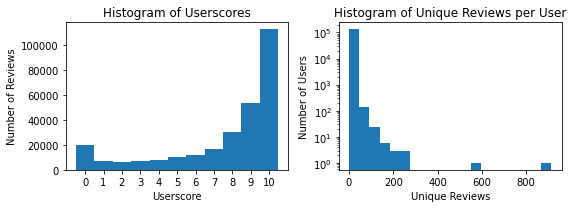

In [14]:
# combined histogram: usersscores, vs unique reviews per user

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 3]}, figsize=(8,3))

ax1.hist(raw_data['Userscore'], bins=np.arange(12)-0.5)
ax1.set_xticks(np.arange(11))
ax1.set_title("Histogram of Userscores")
ax1.set_xlabel("Userscore")
ax1.set_ylabel("Number of Reviews")

ax2.hist(reviews_per_user, bins=20)
ax2.set_yscale("log")
ax2.set_title("Histogram of Unique Reviews per User")
ax2.set_xlabel("Unique Reviews")
ax2.set_ylabel("Number of Users")

fig.tight_layout()

#plt.savefig("figures/combined_histogram.pdf")
plt.show()

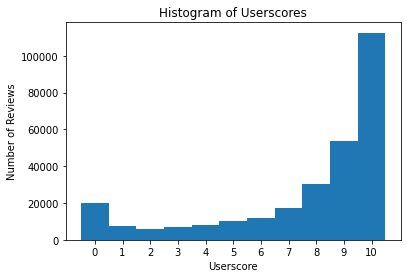

In [15]:
ax = plt.axes()

plt.hist(raw_data['Userscore'], bins=np.arange(12)-0.5)
plt.xticks(np.arange(11))

plt.title("Histogram of Userscores")
plt.xlabel("Userscore")
plt.ylabel("Number of Reviews")

#plt.savefig("figures/userscore_histogram.pdf")

plt.show()

In [17]:
# userscores are discrete values between 0 and 10
np.unique(train_data_fmt["Userscore"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

# FastAI implementation code below:

In [19]:
from fastai.tabular.all import *
from fastai.collab import *

In [21]:
user_name_var = "Username"
rating_name_var = "Userscore"
item_name_var = "Game_ID"
batch_size = 64
valid_pct = 0.0
seed = 69

dls = CollabDataLoaders.from_df(train_data_fmt, user_name=user_name_var,
                                rating_name=rating_name_var, item_name=item_name_var,
                                valid_pct=valid_pct, bs=batch_size, seed=seed)

dls_train = CollabDataLoaders.from_df(train_data_fmt, user_name=user_name_var,
                                rating_name=rating_name_var, item_name=item_name_var,
                                valid_pct=valid_pct, bs=batch_size, seed=seed)

# what if instead of using 10% of the brain, we used 0% of the brain?
# hack to set the validation set of dls to whatever dataset we want
dls_test = CollabDataLoaders.from_df(test_data_fmt, user_name=user_name_var,
                                rating_name=rating_name_var, item_name=item_name_var,
                                valid_pct=valid_pct, bs=batch_size, seed=seed)

dls_valid = CollabDataLoaders.from_df(valid_data_fmt, user_name=user_name_var,
                                rating_name=rating_name_var, item_name=item_name_var,
                                valid_pct=valid_pct, bs=batch_size, seed=seed)

dls_train_valid = CollabDataLoaders.from_df(train_valid_data_fmt, user_name=user_name_var,
                                rating_name=rating_name_var, item_name=item_name_var,
                                valid_pct=0.2, bs=batch_size, seed=seed)


In [22]:
# hyperparams
weight_decay = 0.1 # https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
learning_rate = 5e-3
n_factors = 4
epoch_n = 8

y_range = np.min(train_data_fmt["Userscore"]), np.max(train_data_fmt["Userscore"])
print(y_range)

dls.valid = dls_valid.train

# use_nn = False to use embedded matrices (EmbeddingDotBias)
learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, use_nn=False)

# a bunch of code to test out different optimization functions and convergence rates
#learn = collab_learner(dls, n_factors=n_factors, y_range=(-1, 11), use_nn=False)
#learn = collab_learner(dls_train_valid, n_factors=n_factors, y_range=(-1, 11), use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 10), opt_func=partial(QHAdam, eps=0.001), use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, opt_func=partial(Adam, eps=0.1), use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, loss_func=BaseLoss(nn.MSELoss, axis=-1, floatify=True, is_2d=False), use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, loss_func=BaseLoss(nn.BCELoss, axis=-1, floatify=True, is_2d=False), use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, loss_func=L1LossFlat(), use_nn=False)

(0, 10)


In [23]:
learn.fit_one_cycle(epoch_n, learning_rate, wd=weight_decay)

epoch,train_loss,valid_loss,time
0,11.276718,12.858954,00:08
1,6.785019,10.088130,00:08
2,6.107210,9.585340,00:08
3,5.652064,9.472222,00:08
4,5.589473,9.421856,00:08
5,5.081910,9.415268,00:08
6,4.997841,9.404165,00:08
7,4.768500,9.405083,00:09


In [26]:
def get_sample_rmse(dl_trained, dl_test, learner):
    dl_trained.valid = dl_test.train
    preds, targs = learner.get_preds() # predictions, expected
    
    #print(preds)
    #print(np.unique(preds))
    #print(len(np.unique(preds)))
    
    print("mean", np.mean(preds.numpy()), np.mean(np.ravel(targs)))
   
    return mean_squared_error(preds, np.ravel(targs), squared=False)

In [27]:
get_sample_rmse(dls, dls_test, learn)

mean 6.521222 7.779763620639954


3.1201043

In [40]:
preds, targs = learn.get_preds() # predictions, expected

min / max: 1.6945754 9.873337


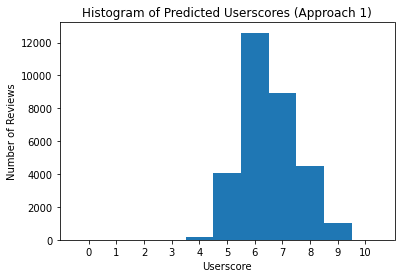

In [45]:
fig = plt.figure()
ax = plt.axes()

ax.hist(preds.numpy(), bins=np.arange(12)-0.5)

plt.xticks(np.arange(11))

print("min / max:", np.min(preds.numpy()), np.max(preds.numpy()))

plt.title("Histogram of Predicted Userscores (Approach 1)")
plt.xlabel("Userscore")
plt.ylabel("Number of Reviews")

plt.savefig("figures/em_1_histogram.pdf")

plt.show()

In [36]:
pcm = ax.pcolormesh(heatmap.T)
heatmap, xedge, yedges = np.histogram2d(preds.numpy(), np.ravel(targs))

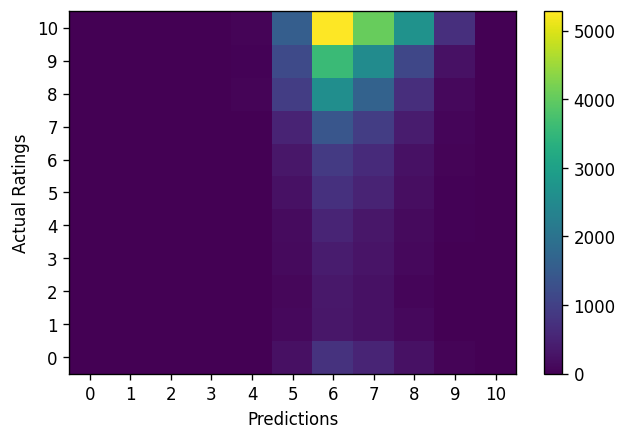

In [37]:
fig = plt.figure(dpi=DPI)
ax = plt.axes()

plt.hist2d(preds.numpy(), np.ravel(targs), bins=np.arange(12)-0.5)
fig.colorbar(pcm, ax=ax)

ax.set_xlabel('Predictions')
ax.set_ylabel('Actual Ratings')

plt.xticks(np.arange(11))
plt.yticks(np.arange(11))


#plt.savefig("figures/em_heatmap.pdf")

plt.show()

In [38]:
def select_hyperparams(n_factors_list, max_epoch_n):
    #print("{nf}: {rmse}")
    results = {}
    for nf in n_factors_list:
        # initializes new instance to reset seed I think
        dls_temp = CollabDataLoaders.from_df(train_data_fmt,
                                        user_name=user_name_var,
                                        rating_name=rating_name_var,
                                        item_name=item_name_var,
                                        valid_pct=valid_pct,
                                        bs=batch_size,
                                        seed=seed
                                        #procs=[Normalize]
                                       )
        # reset dls.train and dls.valid to train / validation sets respectively
        #dls_temp.train = dls_train.train
        # sets the validation set properly
        dls_temp.valid = dls_valid.train

        #learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=(0, 10), use_nn=False)
        learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=y_range, use_nn=False)
        
        for _ep_n in range(max_epoch_n):
            ep_n = _ep_n + 1

            learn_temp.fit_one_cycle(1, learning_rate, wd=weight_decay)

            #preds, targs = learn_temp.get_preds()
            #rmse = mean_squared_error(preds.numpy(), np.ravel(targs.numpy()), squared=False)
            rmse = get_sample_rmse(dls_temp, dls_valid, learn_temp, denormalize=False, round_to_int=False)
            print(f"({nf}, {ep_n}): {rmse}")
            results[(nf, ep_n)] = rmse
        
    return results

def select_eps(eps_values):
    nf = 15
    ep_n = 5
    
    #print("{nf}: {rmse}")
    results = {}
    
    for eps_val in eps_values:
        # initializes new instance to reset seed I think
        dls_temp = CollabDataLoaders.from_df(train_data_fmt,
                                        user_name=user_name_var, rating_name=rating_name_var,
                                        item_name=item_name_var, valid_pct=valid_pct,
                                        bs=batch_size, seed=seed
                                       )
        # reset dls.train and dls.valid to train / validation sets respectively
        #dls_temp.train = dls_train.train
        # sets the validation set properly
        dls_temp.valid = dls_valid.train

        #learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=(0, 10), use_nn=False)
        learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=y_range, use_nn=False,
                                   opt_func=partial(Adam, eps=eps_val))

        learn_temp.fit_one_cycle(ep_n, learning_rate, wd=weight_decay)

        #preds, targs = learn_temp.get_preds()
        #rmse = mean_squared_error(preds.numpy(), np.ravel(targs.numpy()), squared=False)
        rmse = get_sample_rmse(dls_temp, dls_valid, learn_temp, denormalize=False, round_to_int=False)
        print(f"({eps_val}): {rmse}")
        results[(eps_val)] = rmse
        
    return results

In [39]:
#n_factors_list = list(range(5, 105, 5))
n_factors_list = [3, 4, 5, 8, 10, 15, 20, 30, 40, 50, 60, 70]
#print(len(n_factors_list), n_factors_list)

In [104]:
#BaseLoss
#[nn.MSELoss, MSELossFlat, ]
#[Adam, RAdam, QHAdam]
eps_values = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001,]
select_eps(eps_values)

epoch,train_loss,valid_loss,time
0,12.025750,13.568193,00:08
1,9.643478,12.314670,00:07
2,9.250071,12.056247,00:07
3,9.129356,11.999228,00:07
4,9.094336,11.992075,00:07


tensor([7.6893, 5.3650, 5.1668,  ..., 6.5054, 5.0804, 7.0060])
[4.027535  4.1496544 4.1814294 ... 8.228021  8.23782   8.327721 ]
14749
mean 5.6868215 7.835031505563748
(0.1): 3.4627411365509033


epoch,train_loss,valid_loss,time
0,9.895858,12.155046,00:07
1,7.469125,10.444477,00:07
2,7.018986,10.135362,00:07
3,6.939639,10.068408,00:07
4,6.645318,10.059522,00:07


tensor([8.3844, 5.9067, 5.3732,  ..., 7.4747, 5.2324, 7.6485])
[3.7309127 3.7373462 3.853984  ... 8.894071  8.988881  9.02832  ]
14782
mean 6.2615037 7.835031505563748
(0.01): 3.171781301498413


epoch,train_loss,valid_loss,time
0,9.143610,11.672673,00:07
1,6.290950,9.710709,00:07
2,5.573423,9.427032,00:07
3,4.959685,9.367566,00:07
4,4.446834,9.363841,00:07


tensor([7.7027, 6.4590, 5.5837,  ..., 8.2426, 5.4320, 8.6474])
[2.0137045 2.7265737 2.7274873 ... 9.627045  9.630844  9.676637 ]
14767
mean 6.6672297 7.835031505563748
(0.001): 3.0599043369293213


epoch,train_loss,valid_loss,time
0,8.538836,11.538048,00:07
1,5.960445,9.604424,00:07
2,5.189333,9.360195,00:07
3,4.539504,9.323455,00:07
4,4.087103,9.327146,00:07


tensor([7.2816, 6.6936, 5.3559,  ..., 8.6093, 5.5040, 8.8426])
[1.4660432 2.059642  2.1774874 ... 9.822525  9.833214  9.868993 ]
14775
mean 6.756448 7.835031505563748
(0.0001): 3.054288387298584


epoch,train_loss,valid_loss,time
0,8.537252,11.436957,00:07
1,6.199622,9.580405,00:07
2,5.120613,9.375471,00:07
3,4.714288,9.327847,00:08
4,3.870820,9.320628,00:07


tensor([7.3181, 6.2694, 5.3900,  ..., 8.5555, 5.4706, 8.7942])
[1.3224305 2.315721  2.3848746 ... 9.882636  9.895885  9.898983 ]
14777
mean 6.785098 7.835031505563748
(1e-05): 3.0528392791748047


epoch,train_loss,valid_loss,time
0,8.803973,11.557178,00:07
1,6.018870,9.698365,00:07
2,4.962632,9.468944,00:08
3,4.659524,9.431807,00:07
4,4.106270,9.430144,00:07


tensor([7.3524, 6.5762, 5.5723,  ..., 8.5486, 5.4920, 8.9761])
[1.8324481 2.1414623 2.5850189 ... 9.820745  9.833372  9.883066 ]
14785
mean 6.696535 7.835031505563748
(1e-06): 3.0705103874206543


epoch,train_loss,valid_loss,time
0,8.596129,11.488214,00:07
1,5.881458,9.568948,00:07
2,5.392351,9.388147,00:07
3,4.540672,9.346780,00:07
4,4.058786,9.341559,00:07


tensor([6.9350, 6.3415, 5.7397,  ..., 8.6201, 5.3704, 8.7546])
[1.6304458 2.0450206 2.4627779 ... 9.82628   9.91019   9.912144 ]
14783
mean 6.770951 7.835031505563748
(1e-07): 3.0560989379882812


{0.1: 3.4627411,
 0.01: 3.1717813,
 0.001: 3.0599043,
 0.0001: 3.0542884,
 1e-05: 3.0528393,
 1e-06: 3.0705104,
 1e-07: 3.056099}

In [94]:
map_nf_rmse = select_hyperparams(n_factors_list, 8)

epoch,train_loss,valid_loss,time
0,8.613183,11.299406,00:07


(3, 1): 3.3614137172698975


epoch,train_loss,valid_loss,time
0,6.893246,10.109844,00:07


(3, 2): 3.1796281337738037


epoch,train_loss,valid_loss,time
0,6.131683,9.654662,00:07


(3, 3): 3.107067823410034


epoch,train_loss,valid_loss,time
0,5.755854,9.486017,00:07


(3, 4): 3.079742670059204


epoch,train_loss,valid_loss,time
0,5.714503,9.381143,00:07


(3, 5): 3.0625362396240234


epoch,train_loss,valid_loss,time
0,5.594379,9.329872,00:07


(3, 6): 3.0551083087921143


epoch,train_loss,valid_loss,time
0,5.587293,9.307115,00:07


(3, 7): 3.0509610176086426


epoch,train_loss,valid_loss,time
0,5.498016,9.302826,00:07


(3, 8): 3.05026912689209


epoch,train_loss,valid_loss,time
0,8.359947,11.221835,00:07


(4, 1): 3.350184917449951


epoch,train_loss,valid_loss,time
0,6.887998,10.009400,00:07


(4, 2): 3.1637587547302246


epoch,train_loss,valid_loss,time
0,6.029792,9.615848,00:07


(4, 3): 3.1011884212493896


epoch,train_loss,valid_loss,time
0,5.749023,9.477569,00:07


(4, 4): 3.0779807567596436


epoch,train_loss,valid_loss,time
0,5.602070,9.381258,00:07


(4, 5): 3.0624470710754395


epoch,train_loss,valid_loss,time
0,5.382803,9.301937,00:07


(4, 6): 3.0501151084899902


epoch,train_loss,valid_loss,time
0,5.514366,9.267034,00:07


(4, 7): 3.04417085647583


epoch,train_loss,valid_loss,time
0,5.308408,9.262889,00:07


(4, 8): 3.043945550918579


epoch,train_loss,valid_loss,time
0,8.503384,11.249972,00:07


(5, 1): 3.35416579246521


epoch,train_loss,valid_loss,time
0,6.696906,10.095446,00:07


(5, 2): 3.1772122383117676


epoch,train_loss,valid_loss,time
0,5.946614,9.674823,00:07


(5, 3): 3.1106348037719727


epoch,train_loss,valid_loss,time
0,5.540737,9.518631,00:07


(5, 4): 3.0851759910583496


epoch,train_loss,valid_loss,time
0,5.601711,9.381444,00:07


(5, 5): 3.0630342960357666


epoch,train_loss,valid_loss,time
0,5.483553,9.339892,00:07


(5, 6): 3.0564138889312744


epoch,train_loss,valid_loss,time
0,4.979487,9.323096,00:07


(5, 7): 3.0535645484924316


epoch,train_loss,valid_loss,time
0,5.008620,9.284156,00:07


(5, 8): 3.046691656112671


epoch,train_loss,valid_loss,time
0,8.414125,11.251845,00:07


(8, 1): 3.3543450832366943


epoch,train_loss,valid_loss,time
0,6.467555,10.103229,00:07


(8, 2): 3.178215742111206


epoch,train_loss,valid_loss,time
0,5.770679,9.689746,00:07


(8, 3): 3.112788438796997


epoch,train_loss,valid_loss,time
0,5.486622,9.475536,00:07


(8, 4): 3.0783979892730713


epoch,train_loss,valid_loss,time
0,5.274868,9.395760,00:07


(8, 5): 3.065267562866211


epoch,train_loss,valid_loss,time
0,4.859616,9.359983,00:07


(8, 6): 3.0594098567962646


epoch,train_loss,valid_loss,time
0,4.678821,9.356577,00:07


(8, 7): 3.0586795806884766


epoch,train_loss,valid_loss,time
0,4.844494,9.341671,00:07


(8, 8): 3.0566635131835938


epoch,train_loss,valid_loss,time
0,8.476717,11.197233,00:07


(10, 1): 3.346421003341675


epoch,train_loss,valid_loss,time
0,6.541567,10.051790,00:07


(10, 2): 3.17036509513855


epoch,train_loss,valid_loss,time
0,5.622823,9.667965,00:07


(10, 3): 3.109553575515747


epoch,train_loss,valid_loss,time
0,5.141603,9.501186,00:07


(10, 4): 3.082207679748535


epoch,train_loss,valid_loss,time
0,4.990722,9.431671,00:07


(10, 5): 3.0721774101257324


epoch,train_loss,valid_loss,time
0,5.076582,9.403281,00:07


(10, 6): 3.0662457942962646


epoch,train_loss,valid_loss,time
0,4.994081,9.361672,00:07


(10, 7): 3.059577226638794


epoch,train_loss,valid_loss,time
0,4.851108,9.349506,00:07


(10, 8): 3.0572774410247803


epoch,train_loss,valid_loss,time
0,8.168576,11.162755,00:07


(15, 1): 3.341489791870117


epoch,train_loss,valid_loss,time
0,6.549704,9.946314,00:07


(15, 2): 3.1539108753204346


epoch,train_loss,valid_loss,time
0,5.346024,9.558337,00:07


(15, 3): 3.091644763946533


epoch,train_loss,valid_loss,time
0,4.912823,9.411076,00:07


(15, 4): 3.0676214694976807


epoch,train_loss,valid_loss,time
0,4.716810,9.341352,00:07


(15, 5): 3.0561184883117676


epoch,train_loss,valid_loss,time
0,4.513677,9.320388,00:07


(15, 6): 3.0535035133361816


epoch,train_loss,valid_loss,time
0,4.419250,9.300238,00:07


(15, 7): 3.0496926307678223


epoch,train_loss,valid_loss,time
0,4.373082,9.316895,00:07


(15, 8): 3.052072286605835


epoch,train_loss,valid_loss,time
0,7.998365,11.166525,00:07


(20, 1): 3.3418378829956055


epoch,train_loss,valid_loss,time
0,6.018353,9.979086,00:07


(20, 2): 3.158714532852173


epoch,train_loss,valid_loss,time
0,5.323132,9.571515,00:07


(20, 3): 3.093562126159668


epoch,train_loss,valid_loss,time
0,4.888800,9.434449,00:07


(20, 4): 3.0714855194091797


epoch,train_loss,valid_loss,time
0,4.426384,9.339815,00:07


(20, 5): 3.0560050010681152


epoch,train_loss,valid_loss,time
0,4.363253,9.380463,00:07


(20, 6): 3.06233286857605


epoch,train_loss,valid_loss,time
0,4.057150,9.367211,00:07


(20, 7): 3.0610198974609375


epoch,train_loss,valid_loss,time
0,4.034358,9.409785,00:07


(20, 8): 3.068028450012207


epoch,train_loss,valid_loss,time
0,8.036018,11.109079,00:07


(30, 1): 3.3327529430389404


epoch,train_loss,valid_loss,time
0,5.802064,9.840036,00:07


(30, 2): 3.1371877193450928


epoch,train_loss,valid_loss,time
0,4.917459,9.493984,00:07


(30, 3): 3.0812788009643555


epoch,train_loss,valid_loss,time
0,4.316163,9.382085,00:07


(30, 4): 3.063002586364746


epoch,train_loss,valid_loss,time
0,4.303764,9.434155,00:07


(30, 5): 3.0712599754333496


epoch,train_loss,valid_loss,time
0,3.721310,9.368457,00:07


(30, 6): 3.060485601425171


epoch,train_loss,valid_loss,time
0,3.576934,9.339959,00:07


(30, 7): 3.056077718734741


epoch,train_loss,valid_loss,time
0,3.527159,9.344376,00:07


(30, 8): 3.056769847869873


epoch,train_loss,valid_loss,time
0,7.597480,10.998896,00:07


(40, 1): 3.316459894180298


epoch,train_loss,valid_loss,time
0,5.630638,9.730438,00:07


(40, 2): 3.1195363998413086


epoch,train_loss,valid_loss,time
0,4.825264,9.380738,00:07


(40, 3): 3.062894105911255


epoch,train_loss,valid_loss,time
0,4.077387,9.319356,00:07


(40, 4): 3.05279541015625


epoch,train_loss,valid_loss,time
0,3.661644,9.320178,00:07


(40, 5): 3.0527777671813965


epoch,train_loss,valid_loss,time
0,3.523522,9.403942,00:07


(40, 6): 3.066749334335327


epoch,train_loss,valid_loss,time
0,3.267601,9.417680,00:07


(40, 7): 3.0689210891723633


epoch,train_loss,valid_loss,time
0,3.159122,9.405889,00:07


(40, 8): 3.0665030479431152


epoch,train_loss,valid_loss,time
0,7.642199,10.969601,00:07


(50, 1): 3.3121163845062256


epoch,train_loss,valid_loss,time
0,5.453791,9.791038,00:07


(50, 2): 3.128972291946411


epoch,train_loss,valid_loss,time
0,4.422443,9.479143,00:07


(50, 3): 3.0786473751068115


epoch,train_loss,valid_loss,time
0,3.957232,9.473887,00:07


(50, 4): 3.077742576599121


epoch,train_loss,valid_loss,time
0,3.515582,9.453664,00:07


(50, 5): 3.074617624282837


epoch,train_loss,valid_loss,time
0,3.170885,9.393737,00:07


(50, 6): 3.0652835369110107


epoch,train_loss,valid_loss,time
0,3.007710,9.376923,00:07


(50, 7): 3.062129259109497


epoch,train_loss,valid_loss,time
0,2.872657,9.397702,00:07


(50, 8): 3.0658605098724365


epoch,train_loss,valid_loss,time
0,7.511948,10.961658,00:07


(60, 1): 3.3111720085144043


epoch,train_loss,valid_loss,time
0,5.254797,9.825957,00:07


(60, 2): 3.134671211242676


epoch,train_loss,valid_loss,time
0,4.308416,9.516952,00:07


(60, 3): 3.085299015045166


epoch,train_loss,valid_loss,time
0,3.725758,9.450719,00:07


(60, 4): 3.074500322341919


epoch,train_loss,valid_loss,time
0,3.261154,9.427587,00:07


(60, 5): 3.0703647136688232


epoch,train_loss,valid_loss,time
0,2.845326,9.393519,00:07


(60, 6): 3.0645527839660645


epoch,train_loss,valid_loss,time
0,2.780103,9.490278,00:07


(60, 7): 3.080791711807251


epoch,train_loss,valid_loss,time
0,2.617254,9.368851,00:07


(60, 8): 3.0604140758514404


epoch,train_loss,valid_loss,time
0,7.647712,10.910271,00:07


(70, 1): 3.3028805255889893


epoch,train_loss,valid_loss,time
0,5.313463,9.814484,00:07


(70, 2): 3.1333625316619873


epoch,train_loss,valid_loss,time
0,4.149459,9.575229,00:07


(70, 3): 3.0944557189941406


epoch,train_loss,valid_loss,time
0,3.468315,9.478295,00:07


(70, 4): 3.0787978172302246


epoch,train_loss,valid_loss,time
0,3.116683,9.578549,00:07


(70, 5): 3.094512939453125


epoch,train_loss,valid_loss,time
0,2.748307,9.442397,00:07


(70, 6): 3.0734975337982178


epoch,train_loss,valid_loss,time
0,2.512094,9.462255,00:07


(70, 7): 3.0756454467773438


epoch,train_loss,valid_loss,time
0,2.332652,9.428006,00:07


(70, 8): 3.0702075958251953


In [95]:
map_nf_rmse

{(3, 1): 3.3614137,
 (3, 2): 3.1796281,
 (3, 3): 3.1070678,
 (3, 4): 3.0797427,
 (3, 5): 3.0625362,
 (3, 6): 3.0551083,
 (3, 7): 3.050961,
 (3, 8): 3.0502691,
 (4, 1): 3.350185,
 (4, 2): 3.1637588,
 (4, 3): 3.1011884,
 (4, 4): 3.0779808,
 (4, 5): 3.062447,
 (4, 6): 3.050115,
 (4, 7): 3.0441709,
 (4, 8): 3.0439456,
 (5, 1): 3.3541658,
 (5, 2): 3.1772122,
 (5, 3): 3.1106348,
 (5, 4): 3.085176,
 (5, 5): 3.0630343,
 (5, 6): 3.056414,
 (5, 7): 3.0535645,
 (5, 8): 3.0466917,
 (8, 1): 3.354345,
 (8, 2): 3.1782157,
 (8, 3): 3.1127884,
 (8, 4): 3.078398,
 (8, 5): 3.0652676,
 (8, 6): 3.0594099,
 (8, 7): 3.0586796,
 (8, 8): 3.0566635,
 (10, 1): 3.346421,
 (10, 2): 3.170365,
 (10, 3): 3.1095536,
 (10, 4): 3.0822077,
 (10, 5): 3.0721774,
 (10, 6): 3.0662458,
 (10, 7): 3.0595772,
 (10, 8): 3.0572774,
 (15, 1): 3.3414898,
 (15, 2): 3.1539109,
 (15, 3): 3.0916448,
 (15, 4): 3.0676215,
 (15, 5): 3.0561185,
 (15, 6): 3.0535035,
 (15, 7): 3.0496926,
 (15, 8): 3.0520723,
 (20, 1): 3.341838,
 (20, 2): 3.15

In [96]:
sorted(tuple(map_nf_rmse.items()), key=lambda x: x[1])

[((4, 8), 3.0439456),
 ((4, 7), 3.0441709),
 ((5, 8), 3.0466917),
 ((15, 7), 3.0496926),
 ((4, 6), 3.050115),
 ((3, 8), 3.0502691),
 ((3, 7), 3.050961),
 ((15, 8), 3.0520723),
 ((40, 5), 3.0527778),
 ((40, 4), 3.0527954),
 ((15, 6), 3.0535035),
 ((5, 7), 3.0535645),
 ((3, 6), 3.0551083),
 ((20, 5), 3.056005),
 ((30, 7), 3.0560777),
 ((15, 5), 3.0561185),
 ((5, 6), 3.056414),
 ((8, 8), 3.0566635),
 ((30, 8), 3.0567698),
 ((10, 8), 3.0572774),
 ((8, 7), 3.0586796),
 ((8, 6), 3.0594099),
 ((10, 7), 3.0595772),
 ((60, 8), 3.060414),
 ((30, 6), 3.0604856),
 ((20, 7), 3.06102),
 ((50, 7), 3.0621293),
 ((20, 6), 3.0623329),
 ((4, 5), 3.062447),
 ((3, 5), 3.0625362),
 ((40, 3), 3.062894),
 ((30, 4), 3.0630026),
 ((5, 5), 3.0630343),
 ((60, 6), 3.0645528),
 ((8, 5), 3.0652676),
 ((50, 6), 3.0652835),
 ((50, 8), 3.0658605),
 ((10, 6), 3.0662458),
 ((40, 8), 3.066503),
 ((40, 6), 3.0667493),
 ((15, 4), 3.0676215),
 ((20, 8), 3.0680285),
 ((40, 7), 3.068921),
 ((70, 8), 3.0702076),
 ((60, 5), 3.07